# Team FIFA

---
You are working for an advertising analytics consulting company.  Your client, a name brand television network, needs to re-formulate their pricing structure for advertisement slots during soccer matches for new customers.  They also want this new structure to incentivize existing customers to create new partnerships/sponsors with teams and players.  

**Goals:**
- Determine a reasonable metric to decide how exciting a game is.
    - Engineer this feature using existing data.
- Suggest a pricing structure tied to the overall value associated with "game excitement".

**Presentation requirements:**
- At least 50% of presentation must address a non-technical audience.
- Someone who hasn't presented in class yet must take lead on presentation.

In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv("./datasets/fifa_goals.csv")

In [359]:
df['total_goals'] = df['team1score'] + df['team2score']

In [360]:
total_goals = df.groupby('game_id').max()['total_goals']
goals_dict = dict(zip(total_goals.index, total_goals.values))
for i, goals in goals_dict.items():
    indexes = df[df['game_id'] == i].index
    df.loc[indexes, 'total_goals'] = goals

In [361]:
clean_min = [float(value) if value.isdigit() else float(value.replace('+','')) for value in df['minute']]
df['minute'] = clean_min

In [362]:
overtime = df.groupby('game_id').max()['minute'] > 90
overtime = overtime.astype(int)
overtime_dict = dict(zip(overtime.index, overtime.values))
for i, isovertime in overtime_dict.items():
    indexes = df[df['game_id'] == i].index
    df.loc[indexes, 'overtime'] = isovertime

In [363]:
df.head()

,game_id,minute,player,team1score,team2score,total_goals,overtime
0,1,18.0,Schiavio,1,0,8,0.0
1,1,20.0,Orsi,2,0,8,0.0
2,1,29.0,Schiavio,3,0,8,0.0
3,1,57.0,Donelli,3,1,8,0.0
4,1,63.0,Ferrari,4,1,8,0.0


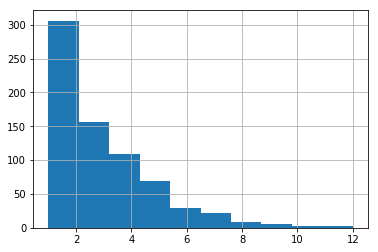

In [364]:
df.groupby('game_id').max()['total_goals'].hist()

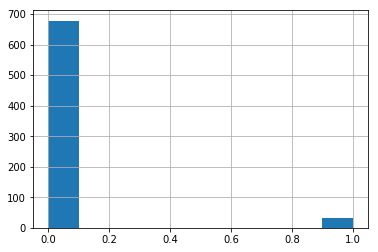

In [365]:
df.groupby('game_id').max()['overtime'].hist()

In [366]:
df.groupby('game_id').max()['overtime'].value_counts()

0.0    678
1.0     31
Name: overtime, dtype: int64

In [367]:
players = df['player'].value_counts(ascending=False)
players_dict = {player: i+1 for i, player in enumerate(players.index)}


In [368]:
player_rank = [players_dict[player] for player in df['player']]
df['player_rank'] = player_rank

In [369]:
games = {}
for game in df['game_id'].unique():
    times = []
    for time in df[df['game_id']==game]['minute'].values:
        times.append(time)
    games[game] = times
# games    
goal_intervals = {}
for game,goals in games.items():
    a = np.array(goals[:-1])
    b = np.array(goals[1:])
    intervals = b - a

    goal_intervals[game] = intervals   

# goal_intervals

df['avg_goal_freq'] = 0
for game,intervals in goal_intervals.items():
    indexes = df[df['game_id']==game].index
    if (len(intervals) == 0):
        df.loc[indexes, 'avg_goal_freq'] = np.inf
    else:
        df.loc[indexes, 'avg_goal_freq'] = np.mean(intervals)

In [370]:
df['avg_goal_freq'].isnull().sum()

0

In [371]:
df['score_diff']= df['team1score'] - df['team2score']

score_diff=df[df['score_diff']==0].groupby(['game_id']).size().sort_values(ascending=False)

df['score_tied_count']=0
for id, values in score_diff.items():
    #print(values)
    
    indexes=df[df['game_id']==id].index
    df.loc[indexes, 'score_tied_count'] = values

In [372]:
# excitement = 0.3*1/rank + 0.1*goals in game + 0.1*overtime + 0.3*1/interval + 0.2*num_ties
weight_rank = 0.3
weight_goals = 0.1
weight_over = 0.1
weight_interval = 0.3
weight_ties = 0.2
excitement = weight_rank/df['player_rank'] + weight_goals*df['total_goals'] + weight_over*df['overtime'] + weight_interval/df['avg_goal_freq'] + weight_ties*df['score_tied_count']

In [373]:
df['excitement'] = excitement

In [374]:
df[df['game_id'] == 276]

,game_id,minute,player,team1score,team2score,total_goals,overtime,player_rank,avg_goal_freq,score_diff,score_tied_count,excitement
654,276,18.0,LeÃ´nidas,1,0,11,1.0,19,10.0,1,3,1.845789
655,276,23.0,Scherfke [p.],1,1,11,1.0,566,10.0,0,3,1.830530
656,276,25.0,Romeu,2,1,11,1.0,202,10.0,1,3,1.831485
657,276,44.0,PerÃ¡cio,3,1,11,1.0,145,10.0,2,3,1.832069
658,276,53.0,Wilimowski,3,2,11,1.0,93,10.0,1,3,1.833226
659,276,59.0,Wilimowski,3,3,11,1.0,93,10.0,0,3,1.833226
660,276,71.0,PerÃ¡cio,4,3,11,1.0,145,10.0,1,3,1.832069
661,276,89.0,Wilimowski,4,4,11,1.0,93,10.0,0,3,1.833226
662,276,93.0,LeÃ´nidas,5,4,11,1.0,19,10.0,1,3,1.845789
663,276,104.0,LeÃ´nidas,6,4,11,1.0,19,10.0,2,3,1.845789


In [375]:
df.groupby('game_id').max().sort_values('excitement', ascending=False).head()

,minute,player,team1score,team2score,total_goals,overtime,player_rank,avg_goal_freq,score_diff,score_tied_count,excitement
game_id,,,,,,,,,,,
276,118.0,Wilimowski,6,5,11,1.0,566,10.000000,2,3,1.845789
21,83.0,Wisnieski,7,3,10,0.0,1014,7.000000,4,3,1.717857
610,111.0,Schnellinger,4,3,7,1.0,1131,17.166667,1,3,1.717476
818,93.0,Lofthouse,4,4,8,1.0,1086,12.714286,2,3,1.525310
830,77.0,Wagner,7,5,12,0.0,385,5.545455,2,1,1.464443


In [376]:
df.groupby('game_id').max().sort_values('excitement', ascending=False).tail()

,minute,player,team1score,team2score,total_goals,overtime,player_rank,avg_goal_freq,score_diff,score_tied_count,excitement
game_id,,,,,,,,,,,
94,48.0,Oganesian,0,1,1,0.0,1180,inf,-1,0,0.100254
683,80.0,Å tibrÃ¡nyi,1,0,1,0.0,1183,inf,1,0,0.100254
530,44.0,KakÃ¡,1,0,1,0.0,1205,inf,1,0,0.100249
313,11.0,Houghton,0,1,1,0.0,1209,inf,-1,0,0.100248
317,84.0,Rekdal,1,0,1,0.0,1215,inf,1,0,0.100247


In [377]:
df.head()

,game_id,minute,player,team1score,team2score,total_goals,overtime,player_rank,avg_goal_freq,score_diff,score_tied_count,excitement
0,1,18.0,Schiavio,1,0,8,0.0,101,10.285714,1,0,0.832137
1,1,20.0,Orsi,2,0,8,0.0,201,10.285714,2,0,0.830659
2,1,29.0,Schiavio,3,0,8,0.0,101,10.285714,3,0,0.832137
3,1,57.0,Donelli,3,1,8,0.0,809,10.285714,2,0,0.829537
4,1,63.0,Ferrari,4,1,8,0.0,309,10.285714,3,0,0.830138


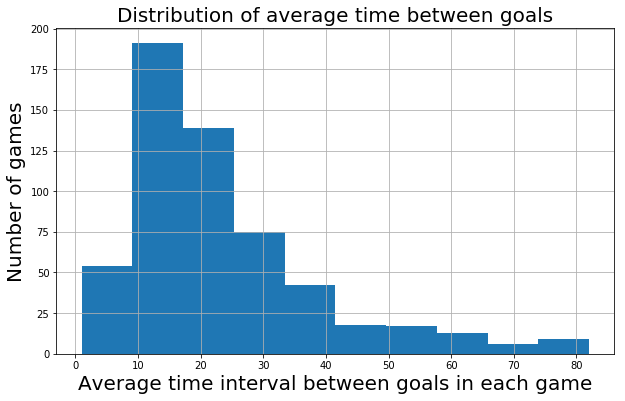

In [378]:
interval = [value if value != np.inf else np.nan for value in df['avg_goal_freq'] ]
df['interval'] = interval
df.groupby('game_id').max()['interval'].hist(figsize=(10,6))
# group_game.groupby('interval').size().sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Distribution of average time between goals', fontsize=20)
plt.ylabel('Number of games', fontsize=20)
plt.xlabel('Average time interval between goals in each game', fontsize=20)
# plt.yticks([0,1], ['overtime', 'no overtime'], fontsize=15)
plt.show()

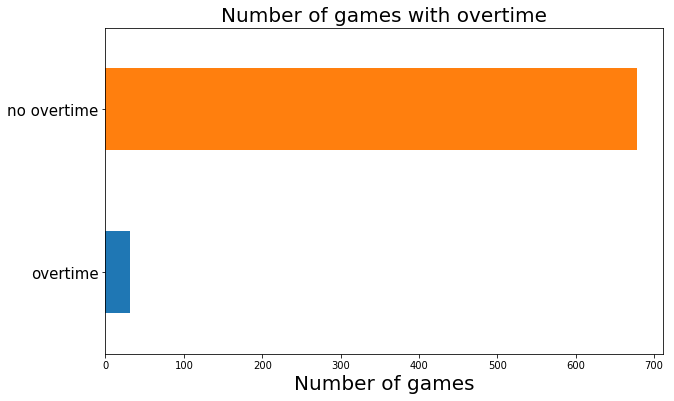

In [379]:
group_game = df.groupby('game_id').max().reset_index()
group_game.groupby('overtime').size().sort_values().plot(kind='barh', figsize=(10,6))
# plt.figure(figsize=(10,5))
# df['score_tied_count'].plot(kind='barh')
plt.title('Number of games with overtime', fontsize=20)
plt.xlabel('Number of games', fontsize=20)
plt.ylabel('', fontsize=20)
plt.yticks([0,1], ['overtime', 'no overtime'], fontsize=15)
plt.show()

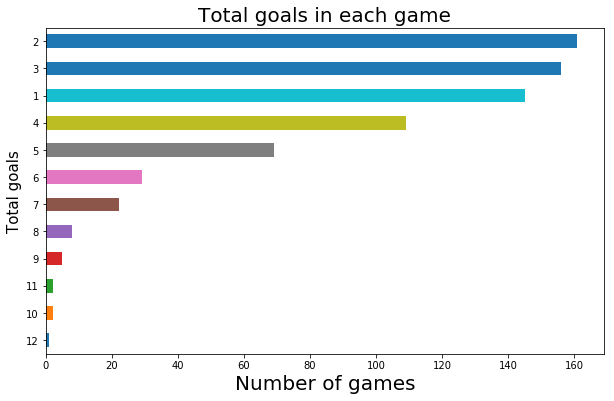

In [380]:
group_game = df.groupby('game_id').max().reset_index()
group_game.groupby('total_goals').size().sort_values().plot(kind='barh', figsize=(10,6))
# plt.figure(figsize=(10,5))
# df['score_tied_count'].plot(kind='barh')
plt.title('Total goals in each game', fontsize=20)
plt.xlabel('Number of games', fontsize=20)
plt.ylabel('Total goals', fontsize=15)
plt.show()

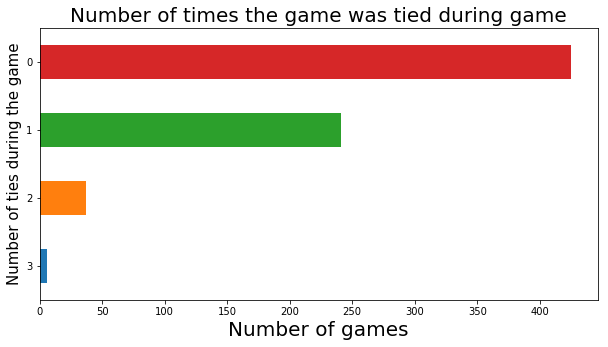

In [381]:
group_game = df.groupby('game_id').max().reset_index()
group_game.groupby('score_tied_count').size().sort_values().plot(kind='barh', figsize=(10,5))
# plt.figure(figsize=(10,5))
# df['score_tied_count'].plot(kind='barh')
plt.title('Number of times the game was tied during game', fontsize=20)
plt.xlabel('Number of games', fontsize=20)
plt.ylabel('Number of ties during the game', fontsize=15)
plt.show()

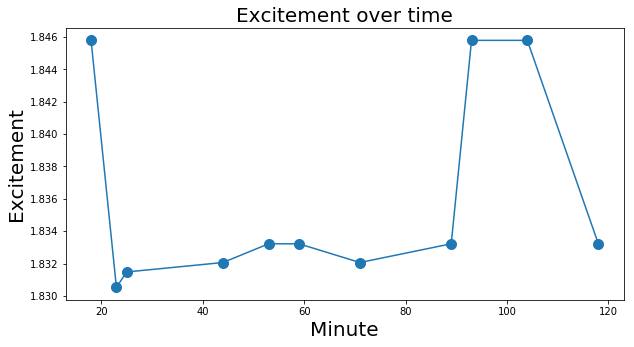

In [382]:
top_game = df[df['game_id'] == 276]
bottom_game = df[df['game_id'] == 317]
plt.figure(figsize=(10,5))
plt.plot(top_game['minute'], top_game['excitement'], marker='o', markersize=10, )
# plt.plot(bottom_game['minute'], bottom_game['excitement'])
plt.title('Excitement over time', fontsize=20)
plt.xlabel('Minute', fontsize=20)
plt.ylabel('Excitement', fontsize=20)
plt.show()

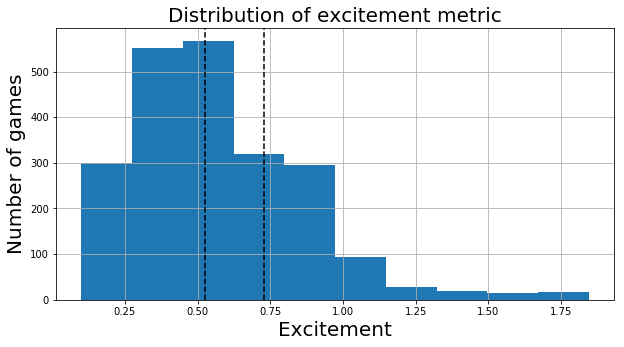

In [383]:
plt.figure(figsize=(10,5))
df['excitement'].hist()
plt.title('Distribution of excitement metric', fontsize=20)
plt.xlabel('Excitement', fontsize=20)
plt.ylabel('Number of games', fontsize=20)
# plt.axvline(x=0.40493222, linestyle='--', color='k')
plt.axvline(x=0.52411499, linestyle='--', color='k')
plt.axvline(x=0.72968576, linestyle='--', color='k')
plt.show()

In [384]:
np.percentile(df['excitement'], [25,50,75])

array([0.40493222, 0.52411499, 0.72968576])

In [385]:
np.mean(df['excitement'])

0.5735933724013914

In [386]:
np.median(df['excitement'])

0.5241149853606601